# Preprocess data and split

In [1]:
import numpy as np
import os
import rasterio
import rasterio.mask
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

In [120]:
# function to load biomass data
def load_biomass_data(year, shape, resolution=250):
    path_bio = f"../data/raw/biomass/{resolution}m/" + f"mapbiomas-brazil-collection-70-acre-{year}.tif"
    with rasterio.open(path_bio) as src:
        if shape is not None:
            bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True)
        else:
            bio_data = src.read(1)
        bio_data = np.squeeze(bio_data)
        out_meta = src.meta
    return bio_data

# function to transform labels to 1=forest, 2=non_forest, 0=unknown
def transform_to_labels(bio_data):
    class_dict = {1:0, 3:0, 4:0, 5:0,49:0, # forest
                10:1,11:1,12:1,32:1,29:1,13:1, 13:1, 50:1, # natural
                14:1,15:1,18:1,19:1,39:1,20:1,40:1,61:1,41:1,36:1,46:1,47:1,48:1,9:1,21:1, # farming
                22:1,23:1,24:1,30:1,25:1, # urban
                26:1,33:1,31:1, # water
                27:255,0:255} # unobserved
    bio_data_new = np.zeros_like(bio_data)
    for key, value in class_dict.items():
        bio_data_new[bio_data == key] = value
    return np.array(bio_data_new, dtype=np.uint8)

def process_data(start_year, nr_years_train, horizon, resolution):
    # parameters to load date
    start_train = start_year # start of training data
    start_target = start_year + nr_years_train  # model has to predict this and following horizon
    start_test = start_target + horizon # model won't see anything after this year

    # load all the different years
    years = np.arange(start_train, start_test+horizon)

    path_bio_processed = f"../data/processed/biomass/{resolution}m/"
    bio_data_dict = {}
    for year in years:
        if not os.path.exists(path_bio_processed + f"biomass_{year}.pt"):
            bio_data = load_biomass_data(year, None, resolution=resolution)
            bio_data = transform_to_labels(bio_data)
            torch.save(torch.from_numpy(bio_data), path_bio_processed + f"biomass_{year}.pt")
        else:
            bio_data = torch.load(path_bio_processed + f"biomass_{year}.pt").numpy()
        bio_data_dict[year] = bio_data

    # calculate deforestation
    deforestation = np.zeros_like(bio_data_dict[start_target - 1], dtype=bool)
    for year in np.arange(start_target, start_target+horizon):
        deforested = bio_data_dict[start_target - 1] - bio_data_dict[year]
        deforestation = deforestation | (deforested == 255)

    # get coordinates
    x = np.arange(deforestation.shape[1])
    y = np.arange(deforestation.shape[0])
    xv, yv = np.meshgrid(x, y)

    data = [xv.flatten(), yv.flatten(), deforestation.flatten()]
    for year in np.arange(start_target, start_test+horizon):
        data.append(bio_data_dict[year].flatten())
    
    dtype = np.int16 if np.max(deforestation.shape) <= 32767 else np.int32
    data = np.array(data, dtype=dtype).T
    data = data[bio_data_dict[start_target - 1].flatten() == 0] # ensure forest cover in last input year
    data = data[np.max(data[:,3:],axis=1) <= 1] # filter out future non-observed points
    return data

In [121]:
start_year = 2006
nr_years_train = 10
horizon = 3

# parameters to load date
start_train = start_year # start of training data
start_target = start_year + nr_years_train  # model has to predict this and following horizon
start_test = start_target + horizon # model won't see anything after this year

# load all the different years
years = np.arange(start_target - 1, start_test+horizon)

bio_data_dict = {}
for year in years:
    bio_data = load_biomass_data(year, None, resolution=30)
    bio_data = transform_to_labels(bio_data)
    bio_data_dict[year] = bio_data

# calculate deforestation
deforestation = np.zeros_like(bio_data_dict[start_target - 1], dtype=bool)
for year in np.arange(start_target, start_target+horizon):
    deforested = bio_data_dict[start_target - 1] - bio_data_dict[year]
    deforestation = deforestation | (deforested == 255)

In [122]:
# get coordinates
x = np.arange(deforestation.shape[1])
y = np.arange(deforestation.shape[0])
xv, yv = np.meshgrid(x, y)

data = [xv.flatten(), yv.flatten(), deforestation.flatten()]
for year in np.arange(start_target, start_test+horizon):
    data.append(bio_data_dict[year].flatten())

dtype = np.int16 if np.max(deforestation.shape) <= 32767 else np.int32
data = np.array(data, dtype=dtype).T
data = data[bio_data_dict[start_target - 1].flatten() == 0] # ensure forest cover in last input year
data = data[np.max(data[:,3:],axis=1) <= 1] # filter out future non-observed points

# Pytorch Dataset

In [28]:
from torch.utils.data import Dataset
class DeforestationDataset(Dataset):
    def __init__(self, dataset, start_year=2006, nr_years_train=10, horizon=3, resolution=30, patch_size=35):
        """
        Args:
            dataset: "train", "val", "test"
        """
        self.dataset = dataset
        self.start_year = start_year
        self.nr_years_train = nr_years_train
        self.horizon = horizon
        self.resolution = resolution
        self.patch_size = patch_size
        
        # dataformat: [x_idx, y_idx, deforested, 2016, 2017, ..., 2021]
        self.data = torch.load(f'../data/processed/{dataset}_data.pt')

        self.bio_data = {}
        path_bio_processed = f"../data/processed/biomass/{resolution}m/"
        for year in np.arange(self.start_year, self.start_year + self.nr_years_train + 2 * horizon):
            self.bio_data[year] = torch.load(path_bio_processed + f"biomass_{year}.pt")
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.dataset == "test":
            labels = self.data[idx, 3+self.horizon:]
            years = np.arange(self.start_year + self.horizon, self.start_year + self.horizon + self.nr_years_train)
        else:
            labels = self.data[idx, 3:3+self.horizon]
            years = np.arange(self.start_year, self.start_year + self.nr_years_train)

        x_idx = self.data[idx, 0]
        y_idx = self.data[idx, 1]
        r = int(self.patch_size/2)

        features = []
        for year in years:
            window = self.bio_data[year][y_idx-r:y_idx+r, x_idx-r:x_idx+r]
            features.append(window)
        features = torch.stack(features)

        return features.float(), labels.float()

In [22]:
train_dataset = DeforestationDataset("train", 2006, 10, 3, 30, 35)

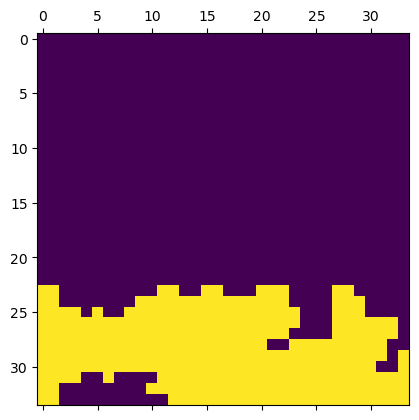

In [23]:
import matplotlib.pyplot as plt
plt.matshow(train_dataset.__getitem__(100)[0][0])

# Dataloaders

In [25]:
def get_data_loaders():
    # load datasets
    train_dataset = DeforestationDataset("train")
    val_dataset = DeforestationDataset("val")
    test_dataset = DeforestationDataset("test")

    # create the train, val and test dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

    return train_loader, val_loader, test_loader

In [26]:
train_loader, val_loader, test_loader = get_data_loaders()

# Define Model

In [15]:
def compile_model():
    input_dim=10
    hidden_dim=[128, 64, 64, 32]
    kernel_size=[(5, 5), (5, 5), (3, 3), (3, 3)]
    stride=[(2, 2), (1, 1), (1, 1), (1, 1)]
    padding=[0, 0, 0, 0]
    dropout=0.2
    output_dim=3

    layers = []

    # convolutional blocks
    for i in range(len(hidden_dim)):
        layer_input_dim = input_dim if i == 0 else hidden_dim[i-1]
        layers.append(
            torch.nn.Conv2d(
            layer_input_dim,
            hidden_dim[i],
            kernel_size[i],
            stride=stride[i],
            padding=padding[i],
        ))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.BatchNorm2d(hidden_dim[i]))

    layers.append(torch.nn.MaxPool2d(2, 2, 0))
    layers.append(torch.nn.Dropout(dropout))
    layers.append(torch.nn.Flatten())

    lin_in = 288 # maybe find way to calculate this
    layers.append(torch.nn.Linear(lin_in, 100))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.BatchNorm1d(100))
    layers.append(torch.nn.Dropout(dropout))
    layers.append(torch.nn.Linear(100, output_dim))

    model = torch.nn.Sequential(*layers)

    return model

In [16]:
import pytorch_lightning as pl
import torchmetrics

class ForestModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        self.model = compile_model()
        self.loss_fn = torch.nn.CrossEntropyLoss() # weights disregarded

        self.auroc = torchmetrics.AUROC(task="binary")
        self.prec = torchmetrics.Precision(task="binary")
        self.recall = torchmetrics.Recall(task="binary")
        self.f1 = torchmetrics.F1Score(task="binary")


    def forward(self, features):
        logits = self.model(features)
        return logits
    
    def shared_step(self, batch, stage):

        features = batch[0]
        target = batch[1]

        logits = self.forward(features)

        logits_loss = logits.unsqueeze(1)
        target_loss = target.unsqueeze(1)
        loss = self.loss_fn(logits_loss, target_loss)
        probs = logits.sigmoid()
        preds = (probs > 0.5).float()

        metrics_batch = {}
        for i in range(preds.shape[1]):
            metrics_batch[f"auc_{i}"] = self.auroc(probs[:,i], target[:,i])
            metrics_batch[f"precision_{i}"] = self.prec(preds[:,i], target[:,i])
            metrics_batch[f"recall_{i}"] = self.recall(preds[:,i], target[:,i])
            metrics_batch[f"f1_{i}"] = self.f1(preds[:,i], target[:,i])
        
        metrics_batch["loss"] = loss

        return metrics_batch

    def shared_epoch_end(self, outputs, stage):

        metrics_epoch = {}
        for key, value in outputs[0].items():
            metrics_epoch[f"{stage}_{key}"] = torch.stack([x[key] for x in outputs]).mean()

        self.log_dict(metrics_epoch, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <BE0CCD9A-269A-30E2-A23C-DA45E89EBB1F> /opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/

In [17]:
model = ForestModel()

In [18]:
trainer = pl.Trainer(
    accelerator='mps', 
    devices=1,
    max_epochs=30,
    log_every_n_steps=5
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Sequential       | 322 K 
1 | loss_fn | CrossEntropyLoss | 0     
2 | auroc   | BinaryAUROC      | 0     
3 | prec    | BinaryPrecision  | 0     
4 | recall  | BinaryRecall     | 0     
5 | f1      | BinaryF1Score    | 0     
---------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.289     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
      File "/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/semester_project/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'DeforestationDataset' on <module '__main__' (built-in)>
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'DeforestationDataset

RuntimeError: DataLoader worker (pid(s) 30385) exited unexpectedly

# Model Evaluation

In [22]:
model = ForestModel.load_from_checkpoint("../lightning_logs/version_2/checkpoints/epoch=9-step=320.ckpt")

In [30]:
trainer = pl.Trainer(
    accelerator='mps', 
    devices=1,
    max_epochs=30,
    log_every_n_steps=5
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
